# 時系列データのベイズ分析

ベクトルや行列を太文字表記していないので要注意

In [1]:
# 必要なライブラリをインポート
import numpy as np
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

## 時系列データと状態空間表現
時系列データの大きな特徴<br>
-> 現在の観測値の分布が過去の観測値に依存する（独立でない）

時点$t$の観測値を$y_t(t=1, \dotsc ,n)$とし，$y_{1:t}=(y_1, \dotsc ,y_t)$とまとめて表記する．<br>
このとき，$y_t$の分布が過去の観測値$y_{1: t-1}$に依存すると仮定すると，$y_{1:n}$の同時分布は以下の通り．
$$
    p(y_{1:n}|\theta) = p(y_1|\theta)p(y_2|y_1, \theta) \times \cdots \times p(y_n|y_{1:n-1}, \theta), \tag{1-1}
$$

時系列データ$y_{1:n}$の挙動を説明する最も基礎的な状態空間モデルは，以下の2つの式から構成される．
$$
    y_t = Z_t \alpha_t + \epsilon_t, \tag{1-2}
$$
$$
    \alpha_{t+1} = T_t \alpha_t + \eta_t, \tag{1-3}
$$

(1-2)式は**観測方程式**，(1-3)式は**状態方程式**と呼ばれる．

|変数|概要|次元|仮定|
|-|-|-|-|
|$y_t$|観測される時系列データ|$m \times 1$ベクトル|ー|
|$\alpha_t$|状態変数．観測されない確率変数|$r \times 1$ベクトル|$\alpha_1 \sim N_r(T_0\alpha_0, H_0H_0^T)$|
|$\epsilon_t$|観測方程式の誤差項|$m \times 1$ベクトル|$e_t=G_tu_t$|
|$\eta_t$|状態方程式の誤差項|$r \times 1$ベクトル|$\eta_t=H_tu_t$|
|$u_t$|観測されない確率変数|$l \times 1$ベクトル|$u_t \sim N_l(0,I)$|
|$Z_t$|ー|$m \times r$行列|ー|
|$G_t$|ー|$m \times l$行列|ー|
|$T_t$|ー|$r \times r$行列|ー|
|$H_t$|ー|$r \times l$行列|ー|

以上をまとめると状態空間モデルは以下の通りに書き直すことができる．
$$
    y_t = Z_t \alpha_t + G_t u_t, \tag{1-4} \\
    \alpha_{t+1} = T_t \alpha_t + H_t u_t, 
$$

さらに，$\{Z_t\}_{t=1}^n, \{G_t\}_{t=1}^n, \{T_t\}_{t=0}^n, \{H_t\}_{t=0}^n, \alpha_0$が全て既知であると仮定すると，(1-4)式における$\alpha_t$を所与としたときの$y_t$と$\alpha_{t+1}$の同時分布は以下の通りになる．
$$
    \begin{bmatrix}
        y_t \\ \alpha_{t+1}
    \end{bmatrix} \bigg| \alpha_t \sim
    N_{m+r} \bigg( 
        \begin{bmatrix}
            Z_t \alpha_t \\ T_t \alpha_t
        \end{bmatrix}, \ 
        \begin{bmatrix}
            G_tG_t^T && G_tH_t^T \\
            H_tG_t^T && H_tH_t^T
        \end{bmatrix}
    \bigg), \tag{1-5}
$$

## 状態空間モデルに関する推論
データ分析における状態空間モデルの主な利用法
1. フィルタリング: 時点$t$の状態変数$\alpha_t$の値を時点$t$までの時系列データ$y_{1:t}$に基づき推測すること
2. 予測: 将来の$\alpha_s$および$y_s(s>t)$の値を時点$t$までの時系列データ$y_{1:t}$に基づき推測すること
3. 平滑化: 観測されなかった過去の状態変数$\alpha_t(t=1, \dotsc , n)$の値を全標本期間のデータ$y_{1:n}$に基づき推測すること
4. パラメータの推定: 未知のパラメータを推定すること


### フィルタリング
フィルタリングのための事後分布は，**ベイズ・フィルター**というアルゴリズムで$p(\alpha_t|y_{1:t-1}), p(y_t|y_{1:t-1}), p(\alpha_t|y_{1:t})$を逐次的に求める．

事後分布$p(\alpha|y_{1:t})$はベイズの定理より以下の関係が成り立つ．
$$
    p(\alpha_t|y_{1:t}) = p(\alpha_t|y_t, y_{1:t-1}) 
    = \frac{p(y_t|alpha_t)p(\alpha_t|y_{1:t-1})}{p(y_t|y_{1:t-1})}, \tag{2-1}
$$
$$
    p(y_t|y_{1:t-1}) = \int_A p(y_t|\alpha_t)p(\alpha_t|y_{1:t-1})d\alpha_t, \tag{2-2}
$$
積分区間$A$は状態変数$\alpha_t$がとりうる値の集合．

さらに，$p(\alpha_t|y_{1:t})$と$p(\alpha_{t+1}|y_{1:t})$の間には以下の関係が成り立つ．
$$
    p(\alpha_{t+1}|y_{1:t}) = 
    \int_A p(\alpha_{t+1}| \alpha_t, y_{1:t}) p(\alpha_t|y_{1:t}) d\alpha_t, 
    \tag{2-3}
$$
(2-3)式を用いることで，時点$t$における$\alpha_t$の事後分布$p(\alpha_t|y_{1:t})$から時点$t+1$における$\alpha_{t+1}$の事前分布$p(\alpha_{t+1}|y_{1:t})$を導出できる．

(1-4)式で仮定されていた$\alpha_1 \sim N_r(T_0\alpha_0, H_0H_0^T)$を$\alpha_1$の$t=1$における事前分布とし，(2-1)~(2-3)式を繰り返し適用することで，$p(\alpha_t|y_{1:t-1}), p(y_t|y_{1:t-1}), p(\alpha_t|y_{1:t})$を逐次的に求めることができる．

※特に$u_t$に正規分布を仮定している状態空間モデル(1-4)では，ベイズ・フィルターの(2-1)式と(2-3)式を解析的に評価することができ，**カルマン・フィルター**と呼ばれる．


### 予測
状態空間モデル(1-4)では$\alpha_{t+s}$が与えられると$y_{t+s}$と$y_{1:t}$が独立になることに注意すると，将来の$y_{t+s}(s \geq 1)$の値の予測分布は以下の通りになる．
$$
    p(y_{t+s}|y_{1:t}) = \int_A p(y_{t+s}|\alpha_{t+s})p(\alpha_{t+s}|y_{1:t})d\alpha_{t+s}, \tag{2-4}
$$
また，$p(\alpha_{t+s}|y_{1:t})$は以下のように与えることが知られている．
$$
    \alpha_{t+s}|y_{1:t} \sim N_k(\hat{\alpha}_t(s), P_t(s)), \tag{2-5}
$$
ここで，
$$
    \hat{\alpha}_t(s) =
        \begin{cases}
            \hat{\alpha}_{t+1} & (s=1) \\
            T_{t+s-1}\hat{\alpha_t}(s-1) & (s \geq 2)
        \end{cases}, 
$$
$$
    P_t(s) = 
        \begin{cases}
            P_{t+1} & (s=1) \\
            T_{t+s-1}P_t(s-1)P_{t+s-1}^T+H_{t+s-1}H_{t+s-1}^T & (s \geq 2)
        \end{cases}, 
$$
(2-5)式を用いると$y_{t+s}$の予測分布は以下のように導出される．
$$
    y_{t+s}|y_{1:t} \sim 
    N_m(Z_{t+s}\hat{\alpha}_t(s), Z_{t+s}P_t(s)Z_{t+s}^T + G_{t+s}G_{t+s}^T)
$$

### 平準化
平準化のための事後分布を考える．

$p(\alpha_t|y_{1:n})$と$p(\alpha_{t+1}|y_{1:n})$の間には以下の関係が成り立つ．
$$
    p(\alpha_t|y_{1:n}) = 
    \int_A p(\alpha_t| \alpha_{t+1}, y_t)p(\alpha_{t+1}|y_{1:n})d\alpha_{t+1}, 
    \tag{2-6}
$$
$p(\alpha_n|y_{1:n})$から始めて$t=n,n-1,\dotsc$と後ろ向きに(2-6)式を適用していけば，$p(\alpha_t|y_{1:n})$を逐次的に求めることができる．

また，状態空間モデル(1-4)では(2-6)式を解析的に評価することができ，これを**カルマン・スムーザー**と呼ぶ．


### パラメータの推定
パラメータ$\theta$の事前分布を$p(\theta)$とすると，状態空間モデル(1-4)の尤度は以下の通りに表すことができることが知られている．
$$
    p(y_{1:n}|\theta) = 
    p(y_1|\theta)\prod_{t=2}^Tp(y_t|y_{1:t-1}, \theta), 
    \tag{2-7}
$$
これにベイズの定理を適用すると，$\theta$の事後分布は以下のように与えられる．
$$
    p(\theta|y_{1:n}) \propto p(y_{1:n}|\theta)p(\theta), \tag{2-8}
$$
状態空間モデル(1-4)のように$u_i$が正規分布に従うときはカルマン・フィルターを適用でき，尤度(2-7)を解析的に導出することができる．

## PyMCによる状態空間モデルのベイズ分析

### ノイズを含むAR(1)過程
AR(1)過程
$$
    x_{t+1} = \rho x_t + \eta_t, \ 
    \eta_t \sim N(0, \omega^2), \ 
    t = 1, \dotsc , n-1, \tag{3-1}
$$
ただし，$|\rho|<1$と仮定し，$t=1$のときの$x_1$の分布を
$$
    x_1 \sim (0, \frac{\omega^2}{1-\rho^2}), \tag{3-2}
$$
とする．

さらに真の値$x_t$は観測されず，ノイズ$\epsilon_t$を含んだ値$y_t$のみが観測可能，すなわち，以下のように仮定する．
$$
    y_t = x_t + \epsilon_t, \
    \epsilon_t \sim N(0, \sigma^2), 
    \tag{3-3}
$$


以下のコードでは，$\omega=\sqrt{0.19}, \rho=0.9$と設定．

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ar1, omega, rho, sigma]


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail   
sigma  0.514  0.030   0.459    0.572      0.000    0.000    4261.0    8142.0  \
rho    0.923  0.021   0.884    0.962      0.000    0.000    4967.0    8087.0   
omega  0.408  0.038   0.339    0.479      0.001    0.001    2102.0    4183.0   

       r_hat  
sigma    1.0  
rho      1.0  
omega    1.0  


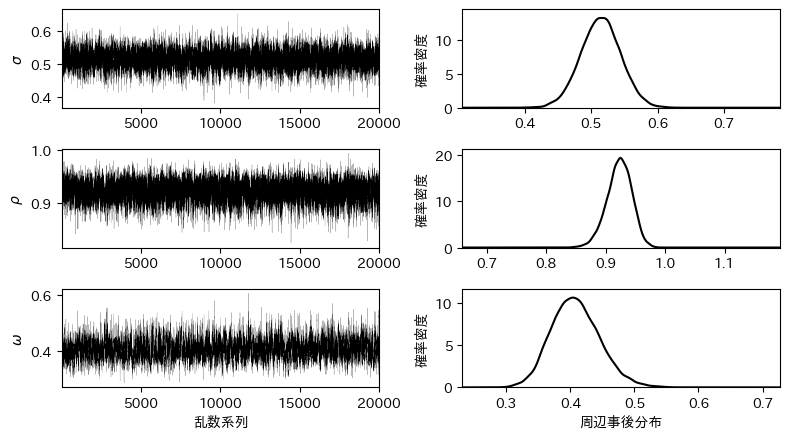

In [4]:
# 5.1: ノイズを含むAR(1)過程
# ノイズを含むAR(1)過程からデータを生成
n = 500
np.random.seed(99)
x = np.empty(n)
x[0] = st.norm.rvs() #定常分布の分散
for t in range(1, n):
    x[t] = 0.9*x[t-1] + st.norm.rvs(scale=np.sqrt(0.19))
y = x + st.norm.rvs(scale=0.5, size=n)

# 事後分布の設定
ar1_model = pm.Model()
with ar1_model:
    sigma = pm.HalfCauchy('sigma', beta=1.0)
    rho = pm.Uniform('rho', lower=-1.0, upper=1.0)
    omega = pm.HalfCauchy('omega', beta=1.0)
    ar1 = pm.AR('ar1', rho, sd=omega, shape=n, 
                init=pm.Normal.dist(sd=omega/pm.math.sqrt(1-rho**2)))
    observation = pm.Normal('y', mu=ar1, sd=sigma, observed=y)

# 事後分布からのサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with ar1_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
param_names = ['sigma', 'rho', 'omega']
print(pm.summary(trace, var_names=param_names))

# 事後分布のグラフの作成
labels = ['$\\sigma$', '$\\rho$', '$\\omega$']
k = len(labels)
fig, ax = plt.subplots(k, 2, num=1, figsize=(8, 1.5*k), facecolor='w')
for idx in range(k):
    mc_trace = trace[param_names[idx]]
    x_min = mc_trace.min() - 0.2*np.abs(mc_trace.min())
    x_max = mc_trace.max() + 0.2*np.abs(mc_trace.max())
    x = np.linspace(x_min, x_max, 250)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[idx, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[idx, 0].set_xlim(1, n_draws*n_chains)
    ax[idx, 0].set_ylabel(labels[idx])
    ax[idx, 1].plot(x, posterior, 'k-')
    ax[idx, 1].set_xlim(x_min, x_max)
    ax[idx, 1].set_ylim(0, 1.1*posterior.max())
    ax[idx, 1].set_ylabel('確率密度')
ax[k-1, 0].set_xlabel('乱数系列')
ax[k-1, 1].set_xlabel('周辺事後分布')
plt.tight_layout()
plt.show()